In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
df = pd.read_csv('train.csv', parse_dates = ['date'])

In [3]:
for column in df.columns:
    print(f"column {column} has {df[column].nunique()} unique values")

column date has 1826 unique values
column store has 10 unique values
column item has 50 unique values
column sales has 213 unique values


In [4]:
df.shape # every item is sold every day in every store. 10*50*1826 = 913,000

(913000, 4)

In [6]:
df = df.set_index('date')

In [5]:
df.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


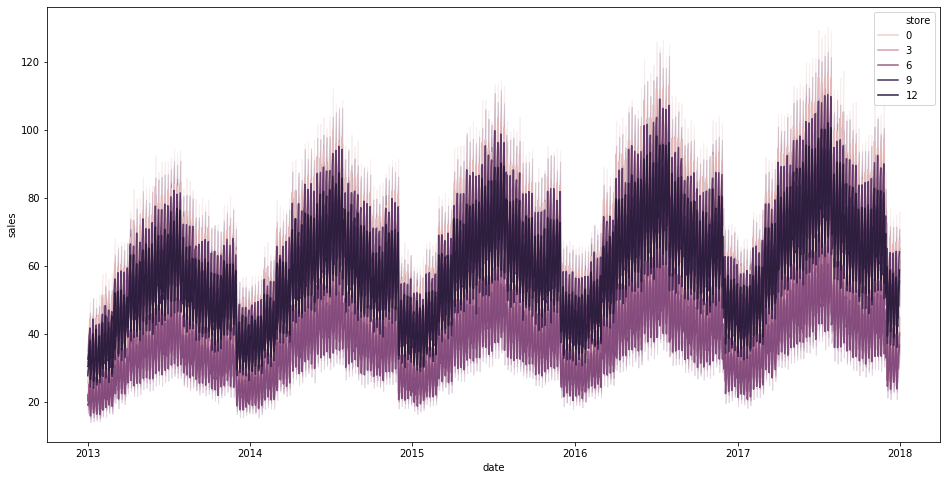

In [8]:
plt.figure(figsize = (16,8))
sns.lineplot(x = df.index,
             y = df['sales'],
#              y = df.groupby(['date','store'])['sales'].sum()
             hue = df['store']
            )

In [9]:
# this is a bit messy, but there's obvious seasonality, and an upwards trend over time

In [ ]:
# models to use:
    # SARIMA - seasonal autoregressive integrated moving average
    # Prophet - facebook's forecasting tool
    # HWES - holt-winter's exponential smoothing
    # xgboost?